In [1]:
library(conflicted)
library(readxl)
library(gtools)
library(plm)
library(tidyverse)
library(modelsummary)
library(huxtable)
library(dplyr)
library(writexl)
library(sjPlot)
library(DescTools)
library(caTools)
library(psych)
library(pcse)
library(stringr)
conflict_prefer("lag", "stats")
conflict_prefer("Mean", "modelsummary")
conflict_prefer("N", "modelsummary")
conflict_prefer("SD", "modelsummary")
conflicted::conflicts_prefer(plm::lag)

# Override default glance.pgmm for summary control
glance.pgmm <- function(x, robust = FALSE, ...) {
  asummary <- summary(x, robust = robust)
  pdim <- attr(asummary, "pdim")
  data.frame(
    N      = pdim$nT$n * (pdim$nT$T - 1),
    Sargan = asummary$sargan$p.value[["chisq"]],
    AR1    = asummary$m1$p.value[1],
    AR2    = asummary$m2$p.value[1]
  )
}
Path.HOME <- path.expand("~")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
#refugeeswelcome

[conflicted] Will prefer stats::lag over any other package.
[conflicted] Will prefer modelsummary::Mean over any other package.
[conflicted] Will prefer modelsummary::N over any other package.
[conflicted] Will prefer modelsummary::SD over any other package.
[conflicted] Removing existing preference.
[conflicted] Will prefer plm::lag over any other package.


In [2]:
gm <- tibble::tribble(
  ~raw, ~clean, ~fmt,
  "N", "N", "%d",
  "Sargan", "Sargan", "%.2f",
  "AR1", "AR(1)", "%.2f",
  "AR2", "AR(2)", "%.2f",
  "nobs", "N", "%d",
  "r.squared","R2","%.2f",
  # "time_effect", "时间效应", "%s",
  # "individual_effect", "个体效应", "%s",
  "utest_top", "拐点", "%s",
  "utest_x_max", "上限", "%.2f",
  "utest_x_min", "下限", "%.2f"
)

SIG <- c("*" = .1, "**" = .05, "***" = .01)

names <- c(
    "SDI" = "SDI",
    "SDI_Average" = "SDI_Average",
    "SDI_Equal" = "SDI_Equal",
    "lnsaving" = "lnsaving",
    
    "lnFDIstock" = "lnFDIstock",
    "I(lnFDIstock^2)" = "lnFDIstock^2",
    "lnFDIstock_winsor" = "lnFDIstock_winsor",      
    "I(lnFDIstock_winsor^2)" = "lnFDIstock_winsor^2",

          
    "lngnic" = "lngnic",
    "WGI" = "WGI",    
    "natural" = "natural",
    "urban" = "urban",
    "war_intensity" = "war_intensity",

    "lag(lnFDIstock)" = "lnFDIstock", 
    "lag(lnFDIstock_winsor)" = "lnFDIstock_winsor",
    
    "lag(lngnic)" = "lngnic",    
    "lag(lngnic2)" = "lngnic2",
    
    "lag(WGI)" = "WGI",    
    "lag(natural)" = "natural",
    "lag(urban)" = "urban",
    "lag(war_intensity)" = "war_intensity"
)

utest <- function(model, var1, var2, fieller = FALSE) {
  dof <- df.residual(model)
  beta <- coef(model)
  covar <- vcov(model)
  b1 <- beta[var1]
  b2 <- beta[var2]
  s11 <- covar[var1, var1]
  s22 <- covar[var2, var2]
  s12 <- covar[var1, var2]
  x_min <- min(model$model[var1])
  x_max <- max(model$model[var1])
  xsq <- df[var1]**2
  mode <- "quad"
  t_min <- (b1 + 2 * (b2) * (x_min)) / sqrt(s11 + 4 * (x_min)^2 * s22 + 4 * (x_min) * s12)
  sl_min <- (b1 + 2 * (b2) * (x_min))
  t_max <- (b1 + 2 * (b2) * (x_max)) / sqrt(s11 + 4 * (x_max)^2 * s22 + 4 * (x_max) * s12)
  sl_max <- (b1 + 2 * (b2) * (x_max))
  top <- -(b1) / (2 * b2)
  t_sac <- min(abs(t_min), abs(t_max))
  if (t_min * t_max > 0) {
    t <- NA
    p <- NA
  } else {
    t <- t_sac
    p <- 2 * pt(t_sac, dof, lower.tail = TRUE)
  }
  stars <- ifelse(p < 0.001, "***", ifelse(p < 0.01, "**", ifelse(p <
    0.05, "*", "")))
  breakpoint <- top
  ret <- list(
    statistics = t,
    p.value = p,
    top = top,
    x_min = x_min,
    x_max = x_max
  )
  ret
}
glance_custom.plm <- function(model, ...) {
  ret <- data.frame(
    time_effect = ifelse(
      model$call$effect == "time" | model$call$effect == "individual",
      "是",
      "否"
    ),
    individual_effect = ifelse(
      model$call$effect == "individual",
      "是",
      "否"
    )
  )
  Xs <- (model %>% formula() %>% as.character())[[3]]
  if (str_detect(Xs, "I\\(.+\\^2\\)")) {
    reg.variables <- (formula(model) %>% as.character())[[3]] %>% str_split("\\s*\\+\\s*")
    utest_res <- utest(model, reg.variables[[1]][1], reg.variables[[1]][2])
    stars <- ifelse(utest_res$p.value < 0.001, "***", ifelse(utest_res$p.value <
      0.01, "**", ifelse(utest_res$p.value < 0.05, "*", "")))
    stars <- ifelse(is.na(utest_res$p.value), "", stars)
    ret[["utest_top"]] <- utest_res$top %>%
      round(2) %>%
      as.character() %>%
      paste0(stars)
    ret[["utest_x_min"]] <- utest_res$x_min %>%
      round(2)
    ret[["utest_x_max"]] <- utest_res$x_max %>%
      round(2)
  }
  ret
}

glance_custom.lm <- function(model, ...) {
  ret <- data.frame(dummy = NA)
  Xs <- (model %>% formula() %>% as.character())[[3]]
  if (str_detect(Xs, "I\\(.+\\^2\\)")) {
    reg.variables <- (formula(model) %>% as.character())[[3]] %>% str_split("\\s*\\+\\s*")
    utest_res <- utest(model, reg.variables[[1]][1], reg.variables[[1]][2])
    stars <- ifelse(utest_res$p.value < 0.001, "***", ifelse(utest_res$p.value <
      0.01, "**", ifelse(utest_res$p.value < 0.05, "*", "")))
    stars <- ifelse(is.na(utest_res$p.value), "", stars)
    ret[["utest_top"]] <- utest_res$top %>% round(4) %>% as.character() %>% paste0(stars)
    ret[["utest_x_min"]] <- utest_res$x_min
    ret[["utest_x_max"]] <- utest_res$x_max
  }
  ret
}

In [3]:
df <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/index_data_regvariables.csv")),
    index = c("Numeric", "Year")
)
df["lnFDIstock_winsor"] <- as.vector(winsor(df["lnFDIstock"], trim = .01))


df["SDI_100"] <- df["SDI"] * 100
df["SDI_Average_100"] <- df["SDI_Average"] * 100
df["SDI_Equal_100"] <- df["SDI_Equal"] * 100
df["SDI_Economy_100"] <- df["SDI_Economy"] * 100
df["SDI_Society_100"] <- df["SDI_Society"] * 100
df["SDI_Resource_100"] <- df["SDI_Resource"] * 100
df["SDI_Ecology_100"] <- df["SDI_Ecology"] * 100


df['l.fdi'] <- lag(df$lnFDIstock,1)

# df["SDI_Average"] <- df["SDI_Average"] * 100
# df["SDI_Equal"] <- df["SDI_Equal"] * 100


# # df['s_lnGNI'] <- as.vector(scale(df['lnGNI']))
# df_sum <- df %>% select("SDI", "lnFDIstock_winsor", "lngnic", "tax", "WGI", "war_intensity", "urban", "war_intensity")
# df_withoutsdi <- df %>% select("lnFDIstock_winsor", "lngnic", "tax",  "WGI","war_intensity", "urban", "war_intensity")
#df <- df[df$Numeric != 480, ]

In [7]:
summary(df$economic)

total sum of squares: 949.3307 
        id       time 
0.84286893 0.07962734 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.376   4.131   4.227   4.867   7.318 

In [10]:
Benchmark <- list(
   "fixed.individual" <- plm(SDI_100 ~ lnFDIstock,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDIstock+ economic,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDIstock+ economic + WGI,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDIstock+ economic + WGI + natural,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDIstock + economic + WGI + natural + urban,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnFDIstock + economic + WGI + natural + urban ,
    data = df, model = "within", effect = "individual"
  ),
    "random"<- plm(SDI_100 ~ lnFDIstock + economic + WGI + natural + urban,
    data = df, model = "random", effect = "individual"
  )
)

Benchmark <- Benchmark %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    gof_map = gm,
    coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
quick_docx(Benchmark, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark.docx"))
Benchmark

,,(1),(2),(3),(4),(5),(6),(7)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7)
1.1,lnFDIstock,1.50***,1.15***,1.16***,1.13***,1.05***,1.05***,1.04***
2,,(0.06),(0.08),(0.08),(0.08),(0.08),(0.08),(0.07)
3,WGI,,,0.46,0.12,-0.17,-0.17,-0.04
4,,,,(0.42),(0.41),(0.41),(0.41),(0.39)
5,natural,,,,-0.09***,-0.08***,-0.08***,-0.08***
6,,,,,(0.01),(0.01),(0.01),(0.01)
7,urban,,,,,-0.54***,-0.54***,-0.52***
8,,,,,,(0.12),(0.12),(0.11)


In [5]:
summary(plm(SDI_100 ~ lngreenfdistock + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "twoways"
  ))

Twoways effects Within Model

Call:
plm(formula = SDI_100 ~ lngreenfdistock + lngnic + WGI + natural + 
    urban + war_intensity, data = df, effect = "twoways", model = "within")

Balanced Panel: n = 24, T = 16, N = 384

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-3.325812 -0.576230 -0.017575  0.535431  5.148781 

Coefficients:
                  Estimate Std. Error t-value  Pr(>|t|)    
lngreenfdistock -0.0183504  0.1154168 -0.1590 0.8737693    
lngnic           0.9540712  0.3400465  2.8057 0.0053105 ** 
WGI             -0.1352400  0.5156107 -0.2623 0.7932565    
natural         -0.0058063  0.0147362 -0.3940 0.6938179    
urban           -0.5849019  0.1745827 -3.3503 0.0008983 ***
war_intensity   -0.4616704  0.1310572 -3.5227 0.0004858 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Total Sum of Squares:    433.05
Residual Sum of Squares: 401.09
R-Squared:      0.073788
Adj. R-Squared: -0.046429
F-statistic: 4.50113 on 6 and 339 DF, p-value: 

In [6]:
#summary(random)
# hausman_test <- phtest(fix, random)
# print(hausman_test)
greenfdi <- list(
    "fixed.individual" <- plm(SDI_100 ~ lngreenfdistock + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lngreenfdistock + I(lngreenfdistock^2) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  ),
  "fixed.individual" <- plm(SDI_100 ~ lnmafdistock + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual" <- plm(SDI_100 ~ lnmafdistock + I(lnmafdistock^2) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  )
)

greenfdi <- greenfdi %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    #gof_map = gm,
    #coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
#quick_docx(Benchmark, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/greenfdi.docx"))
greenfdi

,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
15,lngreenfdistock,0.85***,-0.72***,,
16,,(0.10),(0.24),,
1.1,lngnic,1.40***,0.42,3.25***,2.96***
2,,(0.36),(0.36),(0.31),(0.30)
3,WGI,-1.94***,-1.42**,-1.24*,-1.12*
4,,(0.59),(0.56),(0.64),(0.61)
5,natural,-0.06***,-0.02,-0.08***,-0.07***
6,,(0.02),(0.02),(0.02),(0.02)


In [7]:
#summary(random)
# hausman_test <- phtest(fix, random)
# print(hausman_test)



did <- list(
    "fixed.individual" <- plm(SDI_100 ~  I(posti*treatment) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.individual" <- plm(SDI_100 ~ I(posti*treatment_greenfdi) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.individual" <- plm(SDI_100 ~ I(posti*treatment_mafdi) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "twoways"
  )
)

did <- did %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    #gof_map = gm,
    #coef_map = names,
    output = "huxtable"
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
#quick_docx(Benchmark, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/greenfdi.docx"))
did

,,(1),(2),(3)
,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3)
13,I(posti * treatment),-2.01***,,
14,,(0.38),,
1.1,lngnic,0.85***,0.97***,0.95***
2,,(0.33),(0.34),(0.34)
3,WGI,-0.14,-0.09,-0.14
4,,(0.47),(0.48),(0.49)
5,natural,-0.01,-0.01,-0.01
6,,(0.01),(0.01),(0.01)


In [8]:
?ggpredict

as.data.frame.ggeffects       package:ggeffects        R Documentation

_M_a_r_g_i_n_a_l _e_f_f_e_c_t_s, _a_d_j_u_s_t_e_d _p_r_e_d_i_c_t_i_o_n_s _a_n_d _e_s_t_i_m_a_t_e_d _m_a_r_g_i_n_a_l _m_e_a_n_s
_f_r_o_m _r_e_g_r_e_s_s_i_o_n _m_o_d_e_l_s

_D_e_s_c_r_i_p_t_i_o_n:

     The *ggeffects* package computes estimated marginal means
     (predicted values) for the response, at the margin of specific
     values or levels from certain model terms, i.e. it generates
     predictions by a model by holding the non-focal variables constant
     and varying the focal variable(s).

     ‘ggpredict()’ uses ‘predict()’ for generating predictions, while
     ‘ggeffect()’ computes marginal effects by internally calling
     ‘effects::Effect()’ and ‘ggemmeans()’ uses ‘emmeans::emmeans()’.
     The result is returned as consistent data frame.

_U_s_a_g_e:

     ## S3 method for class 'ggeffects'
     as.data.

In [14]:
seq(0, 170, 30)

[1]   0  30  60  90 120 150

In [17]:
max(df$lnmafdistock)

[1] 11.35619

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Model contains polynomial or cubic / quadratic terms. Consider using
  `terms="lnmafdistock [all]"` to get smooth plots. See also
  package-vignette 'Marginal Effects at Specific Values'.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“font family 'Songti SC' not found in PostScript fo

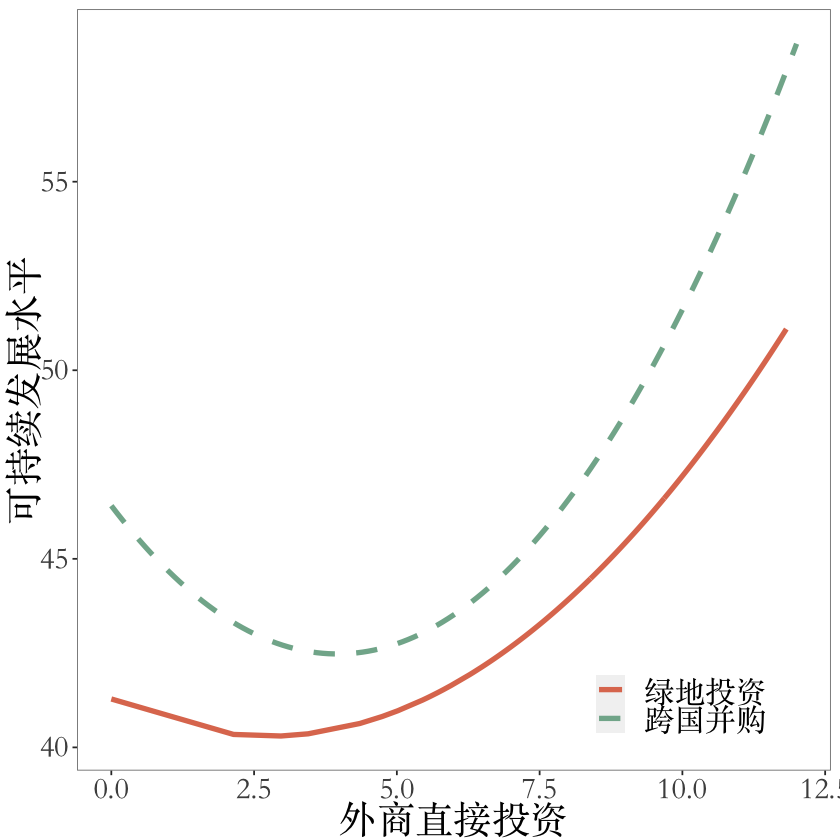

In [16]:
library(ggplot2)
library(ggeffects)

flatui <- c("#DF7A5E", "#F0C986", "#82B29A", "#3C405B")
reg1 <- plm(SDI_100 ~ lngreenfdistock + I(lngreenfdistock^2) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  )
reg2 <- plm(SDI_100 ~ lnmafdistock + I(lnmafdistock^2) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lngreenfdistock [all]")
mydf$group <- "绿地投资"
mydf2 <- ggpredict(reg2, terms = list(lnmafdistock = seq(0, 12, 0.1)))
mydf2$group <- "跨国并购"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("绿地投资", "跨国并购"))
m1<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.8, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展水平",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
# ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同FDI类型.png"), m1)
m1

In [40]:
mydf2

x,predicted,group
<dbl>,<dbl>,<chr>
0.00,46.4081,跨国并购
11.36,56.1840,跨国并购


In [9]:
df_iv <- pdata.frame(read.csv(file.path(path.expand("~"), "OneDrive/PhD Dissertation/Data_Code/Data/ivdata.csv")),
    index = c("Numeric", "Year")
)
# ##内生性检验
iv<- list(
    "lag1" <- plm(SDI_100~ lnFDIstock+ lngnic + WGI + war_intensity + urban + natural | 
         lniv1 + lngnic + WGI + war_intensity + urban + natural, 
         model = "within", 
         effect = "individual",
         data = df_iv),
    "lag1" <- plm(SDI_100~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural| 
         lniv1 + lniv1square + lngnic + WGI + war_intensity + urban + natural, 
         model = "within", 
         effect = "individual",
         data = df_iv),
    "lag1" <- plm(SDI_100~ lnFDIstock+ lngnic + WGI + war_intensity + urban + natural | 
         lag(lnFDIstock,2) + lngnic + WGI + war_intensity + urban + natural, 
         model = "within", 
         effect = "individual",
         data = df_iv),
    "lag1" <- plm(SDI_100~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural| 
         lag(lnFDIstock,2) + I(lag(lnFDIstock,2)^2) + lngnic + WGI + war_intensity + urban + natural, 
         model = "within", 
         effect = "individual",
         data = df_iv)
)
rows <- tribble(
  ~term, ~fixed.time, ~random.time,~fixed.time, ~random.time,
  "SDI", "海运到港距离*汇率","", "lnFDIstock滞后二期","",
)
attr(rows, "position") <- c(1,2)
iv <- iv %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    gof_map = gm,
    coef_map = names,
    output = "huxtable",
    add_rows = rows
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
quick_docx(iv, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/IV.docx"))
iv

Warning message in file(file, "rt"):
“cannot open file '/Users/tcztzy/OneDrive/PhD Dissertation/Data_Code/Data/ivdata.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [10]:
Benchmark_square <- list(
  "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2),
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + natural,
    data = df, model = "within", effect = "individual"
  ),
   "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + natural + urban,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.individual.square" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + natural + urban + war_intensity,
    data = df, model = "within", effect = "individual"
  )
)

Benchmark_square <- modelsummary(
  Benchmark_square,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  output = "huxtable"
)
Benchmark_square <- Benchmark_square %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 1, col = everywhere, 0.4)
quick_docx(Benchmark_square, file = file.path(Path.HOME, 'OneDrive/PhD Dissertation/Regression Results/benchmark_square.docx'))
Benchmark_square

,,(1),(2),(3),(4),(5),(6)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6)
1.1,lnFDIstock,-1.39**,-1.37**,-1.35**,-0.58,-0.49,-0.52
2,,(0.65),(0.64),(0.66),(0.68),(0.66),(0.66)
3,lnFDIstock^2,0.20***,0.18***,0.18***,0.12***,0.10**,0.11**
4,,(0.04),(0.04),(0.04),(0.05),(0.04),(0.05)
5,lngnic,,0.79**,0.81**,1.05***,1.30***,1.31***
6,,,(0.37),(0.39),(0.39),(0.38),(0.38)
7,WGI,,,-0.12,-0.59,-0.11,-0.17
8,,,,(0.62),(0.63),(0.62),(0.62)


In [11]:
library(reticulate)
use_condaenv("new-africa")

sns <- import("seaborn")
plt <- import("matplotlib.pyplot")
flatui <- c("#DF7A5E", "#F0C986", "#82B29A", "#3C405B")
common_tick_params <- function (ax) {
    ax$tick_params(
        direction = "in",
        length=4,
        width=1.5,
        colors="black",
        grid_color="black",
        grid_alpha=0.5,
    )
}
sns$set_palette(flatui)

In [12]:
library(ggplot2)
library(ggeffects)
flatui <- c("#DF7A5E", "#F0C986", "#82B29A", "#3C405B")
reg1 <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + natural + war_intensity + urban,
    data = df, model = "within", effect = "twoways"
  )

mydf <- ggpredict(reg1, terms = "lnFDIstock [all]")

m2<-ggplot(mydf, aes(x = x, y = predicted)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.75, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid')) +
  scale_color_manual(values = c(flatui[1])) + 
  labs(
    y = "可持续发展",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/SDI.png"), m2)

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Saving 7 x 7 in image


data <- df
reg <- plm(SDI_100 ~ lngreenFDI + lngnic + WGI + natural + war_intensity + urban,
           data = data , model = "within", effect = "twoways")

ax <- sns$scatterplot(data = data, x = "lngreenFDI", y = "SDI_100", cmap = "mako")

data$war_intensity <- mean(data$war_intensity)
data$lngnic <- mean(data$lngnic)
data$WGI <- mean(data$WGI)
data$natural <- mean(data$natural)
data$urban <- mean(data$urban)


if (class(reg)[1] == 'plm') {
    fef <- fixef(reg, effect = reg$args$effect)
    y <- predict(reg, data) - fef + mean(fef)
} else {
    y <- predict(reg, data)
}

sns$lineplot(x = data[["lngreenFDI"]], y = y, color = flatui[3], ax = ax)
ax %>% common_tick_params()
plt$show()

fixef(reg, effect = "individual") == fixef(reg)

In [13]:
Benchmark_robust <- list(
   "sdi.fetime" <- plm(SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
    "sdi.fetime" <- plm(SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
    "2020.fetime" <- plm(SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "individual"
  ),
    "lag.fetime" <- plm(SDI_100 ~ lnFDIstock + lag(war_intensity) + lag(WGI) + lag(lngnic) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "individual"
  )

)
rows <- tribble(
  ~term, ~SDI_average.fetime,~SDI_average.fetime,~SDI_average.fetime, ~SDI_average.feindividual,
  "SDI", "替换被解释变量", "解释变量取1%缩尾","删除特殊年份", "控制变量滞后一期",
)
attr(rows, "position") <- c(1, 2)

Benchmark_robust <- modelsummary(
  Benchmark_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)


Benchmark_robust <- Benchmark_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_robust, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_robust.docx"))
Benchmark_robust

,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
1.1,SDI,替换被解释变量,解释变量取1%缩尾,删除特殊年份,控制变量滞后一期
2,lnFDIstock,0.59***,,0.95***,1.25***
3,,(0.12),,(0.14),(0.16)
4,lnFDIstock_winsor,,1.10***,,
5,,,(0.14),,
6,lngnic,1.83***,1.47***,1.75***,1.26***
7,,(0.34),(0.37),(0.37),(0.39)
8,WGI,-0.33,-0.39,-0.31,-1.07*


In [14]:
Benchmark_square_robust <- list(
   "sdi.fetime" <- plm(SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
    "sdi.fetime" <- plm(SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ), 
    "2020.fetime" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "individual"
  ),
    "lag.fetime" <- plm(SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lag(war_intensity) + lag(WGI) + lag(lngnic) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "individual"
  )

)
rows <- tribble(
  ~term, ~SDI_average.fetime,~SDI_average.fetime, ~SDI_average.fetime, ~SDI_average.feindividual,
  "SDI", "替换被解释变量","解释变量取1%缩尾", "删除特殊年份", "控制变量滞后一期",
)
attr(rows, "position") <- c(1)


Benchmark_square_robust <- modelsummary(
  Benchmark_square_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)
Benchmark_square_robust <- Benchmark_square_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)

quick_docx(Benchmark_square_robust, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_square_robust.docx"))
Benchmark_square_robust


,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
1.1,SDI,替换被解释变量,解释变量取1%缩尾,删除特殊年份,控制变量滞后一期
2,lnFDIstock,-0.87,,-0.63,0.03
3,,(0.60),,(0.66),(0.82)
4,lnFDIstock^2,0.10**,,0.11**,0.08
5,,(0.04),,(0.04),(0.05)
6,lnFDIstock_winsor,,-0.40,,
7,,,(0.72),,
8,lnFDIstock_winsor^2,,0.10**,,


reg <- plm(
    SDI ~ lnFDIstock_winsor5 +I(lnFDIstock_winsor5^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
)
fef <- fixef(reg, effect = reg$args$effect)
t <- fef %>% as_tibble()
t["Year"] <- attributes(fef)$index$Year
t["Numeric"] <- attributes(fef)$index$Numeric
t %>% group_by(Numeric) %>% summarise(avg = mean(value), std = sd(value)) %>% arrange(avg)

In [15]:
Benchmark_sub <- list(
  "fixed.individual" <- plm(SDI_Economy_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.individual" <- plm(SDI_Economy_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.time" <- plm(SDI_Society_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.time" <- plm(SDI_Society_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
    "fixed.time" <- plm(SDI_Resource_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.time" <- plm(SDI_Resource_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.time" <- plm(SDI_Ecology_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
    "fixed.time" <- plm(SDI_Ecology_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  )
)
rows <- tribble(
  ~term,~ols, ~fixed.time, ~fixed.individual,~ols,~fixed.time, ~fixed.individual,~fixed.time, ~fixed.individual,
  "", "SDI_Economy", "","SDI_Society","", "SDI_Resource","","SDI_Ecology","",
)
attr(rows, "position") <- c(1)
Benchmark_sub <- Benchmark_sub %>%
  modelsummary(
    fmt = "%.2f",
    stars = SIG,
    estimate = "{estimate}{stars}",
    statistics = "std.error",
    title = "",
    gof_map = gm,
    coef_map = names,
    output = "huxtable",
    add_rows = rows
  ) %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_sub, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_sub.docx"))
Benchmark_sub

,,(1),(2),(3),(4),(5),(6),(7),(8)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7),(8)
1.1,,SDI_Economy,,SDI_Society,,SDI_Resource,,SDI_Ecology,
2,lnFDIstock,0.85*,1.86,2.46***,-5.19***,-0.91***,1.99***,-0.18,0.99
3,,(0.43),(1.54),(0.30),(1.40),(0.15),(0.49),(0.31),(1.11)
4,lnFDIstock^2,,-0.07,,0.53***,,-0.21***,,-0.08
5,,,(0.11),,(0.10),,(0.03),,(0.08)
6,lngnic,5.17***,5.34***,2.92***,1.80**,1.33***,1.80***,-1.71**,-1.51**
7,,(0.98),(1.01),(0.81),(0.80),(0.33),(0.32),(0.71),(0.73)
8,WGI,-1.09,-1.34,1.62,3.53***,1.34***,0.60,-3.13***,-3.42***


In [16]:
Benchmark_Economy_robust1 <- list(
  "winsor.fetime" <- plm(SDI_Economy_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
  "winsor.fetime" <- plm(SDI_Economy_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
   "2020.fetime" <- plm(SDI_Economy_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
  "2020.fetime" <- plm(SDI_Economy_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
    "lag.feindividual" <- plm(SDI_Economy_100 ~ lnFDIstock + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ),
     "lag.feindividual" <- plm(SDI_Economy_100 ~ lnFDIstock + I(lnFDIstock^2) + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ) 

)
rows <- tribble(
  ~term,~ols.2020, ~fetime.2020, ~feindividual.2020, ~stockw2.ols, ~stockw2.fetime, ~stockw2.feindividual,
  "SDI_Economy", "lnFDIstock1%缩尾", "","删除特殊年份","", "控制变量滞后一期", "",
)
attr(rows, "position") <- c(1)
Benchmark_Economy_robust1 <- modelsummary(
  Benchmark_Economy_robust1,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

Benchmark_Economy_robust1 <- Benchmark_Economy_robust1 %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_Economy_robust1, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_Economy_robust1.docx"))
Benchmark_Economy_robust1

,,(1),(2),(3),(4),(5),(6)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6)
1.1,SDI_Economy,lnFDIstock1%缩尾,,删除特殊年份,,控制变量滞后一期,
2,lnFDIstock,,,0.69,1.71,1.69***,2.13
3,,,,(0.44),(1.55),(0.54),(1.98)
4,lnFDIstock^2,,,,-0.07,,-0.03
5,,,,,(0.11),,(0.13)
6,lnFDIstock_winsor,0.89*,2.21,,,,
7,,(0.45),(1.68),,,,
8,lnFDIstock_winsor^2,,-0.09,,,,


In [17]:
Benchmark_Society_robust1 <- list(
  "winsor.fetime" <- plm(SDI_Society_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
  "winsor.fetime" <- plm(SDI_Society_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "individual"
  ),
   "2020.fetime" <- plm(SDI_Society_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "individual"
  ),
  "2020.fetime" <- plm(SDI_Society_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "individual"
  ),
    "lag.feindividual" <- plm(SDI_Society_100 ~ lnFDIstock + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "individual"
  ),
     "lag.feindividual" <- plm(SDI_Society_100 ~ lnFDIstock + I(lnFDIstock^2) + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "individual"
  ) 

)
rows <- tribble(
  ~term,~ols.2020, ~fetime.2020, ~feindividual.2020, ~stockw2.ols, ~stockw2.fetime, ~stockw2.feindividual,
  "SDI_Society", "lnFDIstock1%缩尾", "","删除特殊年份","", "控制变量滞后一期", "",
)
attr(rows, "position") <- c(1)
Benchmark_Society_robust1 <- modelsummary(
  Benchmark_Society_robust1,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

Benchmark_Society_robust1 <- Benchmark_Society_robust1 %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_Society_robust1, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_Society_robust1.docx"))
Benchmark_Society_robust1

,,(1),(2),(3),(4),(5),(6)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6)
1.1,SDI_Society,lnFDIstock1%缩尾,,删除特殊年份,,控制变量滞后一期,
2,lnFDIstock,,,2.24***,-4.88***,2.84***,-5.07***
3,,,,(0.30),(1.39),(0.35),(1.73)
4,lnFDIstock^2,,,,0.50***,,0.53***
5,,,,,(0.10),,(0.11)
6,lnFDIstock_winsor,2.66***,-4.74***,,,,
7,,(0.30),(1.53),,,,
8,lnFDIstock_winsor^2,,0.50***,,,,


In [18]:
Benchmark_Resource_robust1 <- list(
  "winsor.fetime" <- plm(SDI_Resource_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
  "winsor.fetime" <- plm(SDI_Resource_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
   "2020.fetime" <- plm(SDI_Resource_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
  "2020.fetime" <- plm(SDI_Resource_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
    "lag.feindividual" <- plm(SDI_Resource_100 ~ lnFDIstock + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ),
     "lag.feindividual" <- plm(SDI_Resource_100 ~ lnFDIstock + I(lnFDIstock^2) + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ) 

)
rows <- tribble(
  ~term,~ols.2020, ~fetime.2020, ~feindividual.2020, ~stockw2.ols, ~stockw2.fetime, ~stockw2.feindividual,
  "SDI_Resource", "lnFDIstock1%缩尾", "","删除特殊年份","", "控制变量滞后一期", "",
)
attr(rows, "position") <- c(1)
Benchmark_Resource_robust1 <- modelsummary(
  Benchmark_Resource_robust1,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

Benchmark_Resource_robust1 <- Benchmark_Resource_robust1 %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_Resource_robust1, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_Resource_robust1.docx"))
Benchmark_Resource_robust1

,,(1),(2),(3),(4),(5),(6)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6)
1.1,SDI_Resource,lnFDIstock1%缩尾,,删除特殊年份,,控制变量滞后一期,
2,lnFDIstock,,,-0.81***,1.90***,-1.12***,2.18***
3,,,,(0.15),(0.49),(0.19),(0.66)
4,lnFDIstock^2,,,,-0.20***,,-0.23***
5,,,,,(0.03),,(0.04)
6,lnFDIstock_winsor,-0.99***,1.92***,,,,
7,,(0.15),(0.54),,,,
8,lnFDIstock_winsor^2,,-0.21***,,,,


In [19]:
Benchmark_Ecology_robust1 <- list(
  "winsor.fetime" <- plm(SDI_Ecology_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
  "winsor.fetime" <- plm(SDI_Ecology_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df, model = "within", effect = "twoways"
  ),
   "2020.fetime" <- plm(SDI_Ecology_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
  "2020.fetime" <- plm(SDI_Ecology_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$Year != 2020, ], model = "within", effect = "twoways"
  ),
    "lag.feindividual" <- plm(SDI_Ecology_100 ~ lnFDIstock + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ),
     "lag.feindividual" <- plm(SDI_Ecology_100 ~ lnFDIstock + I(lnFDIstock^2) + lag(lngnic) + lag(war_intensity) + lag(WGI) + lag(urban) + lag(natural),
    data = df, model = "within", effect = "twoways"
  ) 

)
rows <- tribble(
  ~term,~ols.2020, ~fetime.2020, ~feindividual.2020, ~stockw2.ols, ~stockw2.fetime, ~stockw2.feindividual,
  "SDI_Ecology", "lnFDIstock1%缩尾", "","删除特殊年份","", "控制变量滞后一期", "",
)
attr(rows, "position") <- c(1)
Benchmark_Ecology_robust1 <- modelsummary(
  Benchmark_Ecology_robust1,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

Benchmark_Ecology_robust1 <- Benchmark_Ecology_robust1 %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(Benchmark_Ecology_robust1, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/benchmark_Ecology_robust1.docx"))
Benchmark_Ecology_robust1

,,(1),(2),(3),(4),(5),(6)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6)
1.1,SDI_Ecology,lnFDIstock1%缩尾,,删除特殊年份,,控制变量滞后一期,
2,lnFDIstock,,,-0.22,0.78,-0.27,1.21
3,,,,(0.30),(1.05),(0.38),(1.39)
4,lnFDIstock^2,,,,-0.07,,-0.10
5,,,,,(0.07),,(0.09)
6,lnFDIstock_winsor,-0.23,0.53,,,,
7,,(0.33),(1.22),,,,
8,lnFDIstock_winsor^2,,-0.05,,,,


In [ ]:
### 断点回归
# library(rdrobust)
# out = lm(df$SDI[df$lnFDIstock_w < 0 & df$lnFDIstock_w >= -20] ~ df$lnFDIstock_w[df$lnFDIstock_w < 0 & df$lnFDIstock_w >= -20])
# left_intercept = out$coefficients[1]
# out = lm(df$SDI[df$lnFDIstock_w >= 0 & df$lnFDIstock_w <= 20] ~ df$lnFDIstock_w[df$lnFDIstock_w >= 0 & df$lnFDIstock_w <= 20])
# right_intercept = out$coefficients[1]
# difference = right_intercept - left_intercept
# print(paste("The RD estimator is", difference, sep = " "))


In [ ]:
# df <- pdata.frame(read.csv(file.path(path.expand('~'), 'OneDrive/PhD Dissertation/Data_Code/Data/index_data_regvariables.csv')),
#                   index=c("Numeric","Year"))

# summary(pgmm(SDI ~ lag(SDI) + lnFDIstock + lngnic + WGI + natural + war_intensity + 
#     urban | lag(SDI, 13) | war_intensity + natural + WGI, data = df, effect = "individual", model = "twosteps", 
#     collapse = TRUE, transformation = "ld"))

In [20]:
df["lnFDIstock_scale"] <- as.vector(scale(df["lnFDIstock"], scale = FALSE))

df["lnFDIstock_scale"] <- as.vector(scale(df["lnFDIstock"], scale = FALSE))

df["lngnic_scale"] <- as.vector(scale(df["lngnic"], scale = FALSE))

In [21]:
## 经济发展阶段的影响
low_middle <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, 
  " ", "低收入", "", "中等收入", "",
)
attr(rows, "position") <- c(1)
low_middle <- modelsummary(
  low_middle,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

low_middle <- low_middle %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(low_middle, file = file.path(Path.HOME, 'OneDrive/PhD Dissertation/Regression Results/low-middle.docx'))
low_middle

,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
1.1,,低收入,,中等收入,
2,lnFDIstock,0.69***,-2.03***,1.57***,2.97*
3,,(0.11),(0.75),(0.26),(1.62)
4,lnFDIstock^2,,0.20***,,-0.09
5,,,(0.05),,(0.10)
6,lngnic,1.89***,1.46***,1.02,1.19*
7,,(0.37),(0.38),(0.63),(0.66)
8,WGI,1.00**,1.97***,-5.59***,-5.82***


In [22]:
library(ggplot2)
library(ggeffects)

flatui <- c("#DF7A5E", "#F0C986", "#82B29A", "#3C405B")
reg1 <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 0, ], model = "within", effect = "individual"
  )
reg2 <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 1, ], model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lnFDIstock [all]")
mydf$group <- "低收入国家"
mydf2 <- ggpredict(reg2, terms = "lnFDIstock [all]")
mydf2$group <- "中等收入国家"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("低收入国家", "中等收入国家"))
m1<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.8, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展水平",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同收入类型.png"), m1)

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Saving 7 x 7 in image


In [23]:
## 经济发展阶段的影响
low_middle_robust <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2020 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2020 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2020 == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2020 == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$incomegroup2013 == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual,
  " ", "低收入", "", "中等收入", "", "低收入", "", "中等收入", "",
)
attr(rows, "position") <- c(1)
low_middle_robust <- modelsummary(
  low_middle_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

low_middle_robust <- low_middle_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(low_middle_robust, file = file.path(Path.HOME, 'OneDrive/PhD Dissertation/Regression Results/low-middle_robust.docx'))
low_middle_robust

,,(1),(2),(3),(4),(5),(6),(7),(8)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7),(8)
1.1,,低收入,,中等收入,,低收入,,中等收入,
2,lnFDIstock,0.82***,-2.63***,1.43***,2.22*,,,,
3,,(0.14),(0.97),(0.22),(1.27),,,,
4,lnFDIstock^2,,0.25***,,-0.05,,,,
5,,,(0.07),,(0.08),,,,
6,lnFDIstock_winsor,,,,,0.76***,-1.66*,1.59***,2.69
7,,,,,,(0.12),(0.86),(0.26),(1.63)
8,lnFDIstock_winsor^2,,,,,,0.18***,,-0.07


In [24]:
## 资源丰富国家

resourcecountry <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, 
  " ", "市场和效率寻求型FDI", "", "非市场和效率寻求型FDI", ""  
)
attr(rows, "position") <- c(1)
resourcecountry <- modelsummary(
  resourcecountry,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)
resourcecountry <- resourcecountry %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(resourcecountry, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/resourcecountry.docx"))
resourcecountry


,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
1.1,,市场和效率寻求型FDI,,非市场和效率寻求型FDI,
2,lnFDIstock,1.34***,-2.58***,0.59***,-1.73*
3,,(0.14),(0.80),(0.20),(0.89)
4,lnFDIstock^2,,0.28***,,0.16***
5,,,(0.06),,(0.06)
6,lngnic,-0.02,-0.42,2.03***,1.67***
7,,(0.51),(0.48),(0.49),(0.50)
8,WGI,2.87***,4.13***,-4.68***,-4.62***


In [25]:
library(ggplot2)
library(ggeffects)

reg1 <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  )
reg2 <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lnFDIstock [all]")
mydf$group <- "市场和效率寻求型"
mydf2 <- ggpredict(reg2, terms = "lnFDIstock [all]")
mydf2$group <- "非市场和效率寻求型"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("市场和效率寻求型", "非市场和效率寻求型"))
m2<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.75, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/FDI投资动机.png"), m2)

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Saving 7 x 7 in image


In [26]:
## 资源丰富国家

resourcecountry_robust <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 0, ], model = "within", effect = "individual"
  ),
  "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$IMFgroup == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual,  ~fetime, ~feindividual, ~fetime, ~feindividual,
  " ", "市场和效率寻求型FDI", "", "非市场和效率寻求型FDI", "","市场和效率寻求型FDI", "", "非市场和效率寻求型FDI", "" 
)
attr(rows, "position") <- c(1)
resourcecountry_robust <- modelsummary(
  resourcecountry_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)
resourcecountry_robust <- resourcecountry_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(resourcecountry_robust, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/resourcecountry_robust.docx"))
resourcecountry_robust

,,(1),(2),(3),(4),(5),(6),(7),(8)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7),(8)
1.1,,市场和效率寻求型FDI,,非市场和效率寻求型FDI,,市场和效率寻求型FDI,,非市场和效率寻求型FDI,
2,lnFDIstock,,,,,1.02***,-3.39***,0.13,-1.85**
3,,,,,,(0.17),(0.97),(0.17),(0.76)
4,lnFDIstock^2,,,,,,0.31***,,0.13***
5,,,,,,,(0.07),,(0.05)
6,lnFDIstock_winsor,1.43***,-1.83**,0.64***,-1.99**,,,,
7,,(0.14),(0.89),(0.21),(0.97),,,,
8,lnFDIstock_winsor^2,,0.23***,,0.17***,,,,


In [27]:
## 内陆国家
landlockcountry <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, 
  " ", "沿海国家", "", "内陆国", ""  
)
attr(rows, "position") <- c(1)
landlockcountry <- modelsummary(
  landlockcountry,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)
landlockcountry <- landlockcountry %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(landlockcountry, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/landlockcountry.docx"))
landlockcountry


,,(1),(2),(3),(4)
,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4)
1.1,,沿海国家,,内陆国,
2,lnFDIstock,1.25***,1.49,0.85***,-3.13***
3,,(0.22),(1.11),(0.15),(0.96)
4,lnFDIstock^2,,-0.02,,0.29***
5,,,(0.07),,(0.07)
6,lngnic,1.14**,1.17**,1.25**,1.24***
7,,(0.53),(0.55),(0.50),(0.46)
8,WGI,-0.88,-0.92,-0.27,1.25*


In [28]:
## 内陆国的稳健性检验
landlock_robust <- list(
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual, 
 " ", "解释变量1%缩尾", "", "", "","替换被解释变量", "", "", "", 
  " ", "沿海国家", "", "内陆国", "","沿海国家", "", "内陆国", ""
)
attr(rows, "position") <- c(1,2)

landlock_robust <- modelsummary(
  landlock_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

landlock_robust <- landlock_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 3, col = everywhere, 0.4)
quick_docx(landlock_robust, file = file.path(Path.HOME, 'OneDrive/PhD Dissertation/Regression Results/landlock_robust.docx'))
landlock_robust

,,(1),(2),(3),(4),(5),(6),(7),(8)
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,(1),(2),(3),(4),(5),(6),(7),(8)
1.1,,解释变量1%缩尾,,,,替换被解释变量,,,
2,,沿海国家,,内陆国,,沿海国家,,内陆国,
3,lnFDIstock,,,,,0.98***,1.21,0.32**,-1.73
4,,,,,,(0.19),(0.96),(0.16),(1.08)
5,lnFDIstock^2,,,,,,-0.02,,0.15*
6,,,,,,,(0.06),,(0.08)
7,lnFDIstock_winsor,1.26***,1.30,0.92***,-3.34***,,,,
8,,(0.22),(1.12),(0.15),(1.10),,,,


In [29]:
reg1 <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 0, ], model = "within", effect = "individual"
  )
reg2 <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$landlock == 1, ], model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lnFDIstock [all]")
mydf$group <- "沿海国家"
mydf2 <- ggpredict(reg2, terms = "lnFDIstock [all]")
mydf2$group <- "内陆国家"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("沿海国家", "内陆国家"))
m3<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.8, 0.2)
  ) + 
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "SDI",
    x = get_x_title(mydf),
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/内陆国与否.png"), m3)

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Warning message in predict.plm(model, newdata = fitfram, type = pr.type, level = 0, :
“Data supplied in argument 'newdata' is not a pdata.frame; weighted mean of fixed effects as in original model used for prediction, see ?predict.plm.”
Could not compute variance-covariance matrix of predictions. No
  confidence intervals are returned.

Saving 7 x 7 in image


In [30]:
## 教育水平国家

education <- list(
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  ),
  "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, 
  " ", "高教育水平", "", "低教育水平", ""  
)
attr(rows, "position") <- c(1)
education <- modelsummary(
  education,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)
education <- education %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 2, col = everywhere, 0.4)
quick_docx(education, file = file.path(Path.HOME, "OneDrive/PhD Dissertation/Regression Results/education.docx"))
education


ERROR: Error in plm.fit(data, model, effect, random.method, random.models, random.dfcor, : 0 (non-NA) cases


In [ ]:
library(ggplot2)
library(ggeffects)

reg1 <- plm(
    SDI_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  )
reg2 <- plm(
    SDI_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lnFDIstock [all]")
mydf$group <- "高人力资本水平"
mydf2 <- ggpredict(reg2, terms = "lnFDIstock [all]")
mydf2$group <- "低人力资本水平"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("高人力资本水平", "低人力资本水平"))
m2<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.75, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同人力资本.png"), m2)

In [ ]:
## 人力资本分组稳健性检验1
edu_robust <- list(
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu42020 ==1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu42020 ==1, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu42020 ==0, ], model = "within", effect = "individual"
  ),
    "FE_time" <- plm(
    SDI_Equal_100 ~ lnFDIstock + I(lnFDIstock^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu42020 ==0, ], model = "within", effect = "individual"
  )
)
rows <- tribble(
  ~term, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual, ~fetime, ~feindividual, 
 " ", "解释变量1%缩尾", "", "", "","更改标准", "", "", "", 
  " ", "高人力资本", "", "低人力资本", "","高人力资本", "", "低人力资本", ""
)
attr(rows, "position") <- c(1,2)

edu_robust <- modelsummary(
  edu_robust,
  fmt = "%.2f",
  stars = SIG,
  estimate = "{estimate}{stars}",
  statistics = "std.error",
  title = "",
  gof_map = gm,
  coef_map = names,
  add_rows = rows,
  output = "huxtable"
)

edu_robust <- edu_robust %>%
  set_align(everywhere, everywhere, "center") %>%
  set_top_border(row = 1, col = everywhere) %>%
  set_top_border(row = -1, col = everywhere, 0) %>%
  set_bottom_border(row = 3, col = everywhere, 0.4)
quick_docx(edu_robust, file = file.path(Path.HOME, 'OneDrive/PhD Dissertation/Regression Results/edu_robust.docx'))
edu_robust


In [ ]:
library(ggplot2)
library(ggeffects)

reg1 <- plm(
    SDI_100 ~ lnFDIstock_winsor + I(lnFDIstock_winsor^2) + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==1, ], model = "within", effect = "individual"
  )
reg2 <- plm(
    SDI_100 ~ lnFDIstock_winsor + lngnic + WGI + war_intensity + urban + natural,
    data = df[df$edu2020 ==0, ], model = "within", effect = "individual"
  )
mydf <- ggpredict(reg1, terms = "lnFDIstock_winsor [all]")
mydf$group <- "高人力资本水平"
mydf2 <- ggpredict(reg2, terms = "lnFDIstock_winsor [all]")
mydf2$group <- "低人力资本水平"
final_df <- mydf %>% rows_append(mydf2)
final_df$group <- factor(final_df$group, levels = c("高人力资本水平", "低人力资本水平"))
m2<-ggplot(final_df, aes(x = x, y = predicted, colour = group, linetype = group)) +
  theme(
    text = element_text(family='Songti SC',size = 23),
    panel.background = element_rect(fill = "white", colour = "grey50"),
    panel.grid = element_blank(),
    legend.position = c(0.75, 0.1)
  ) +  
  geom_line(size=1.5) +
  scale_linetype_manual(values = c('solid', 'dashed')) +
  scale_color_manual(values = c(flatui[1], flatui[3])) + 
  labs(
    y = "可持续发展",
    x = "外商直接投资",
    colour = element_blank(),
    linetype = element_blank()
  )
ggsave(file.path(Path.HOME, "OneDrive/PhD Dissertation/Pictures/不同人力资本_winsor.png"), m2)